XGBoostのチューニング

In [4]:
#https://qiita.com/c60evaporator/items/a9a049c3469f6b4872c6
from mymodule import MLs
from mymodule import myfunc as mf
import numpy as np
import pandas as pd
import glob
import cv2
import pickle
import os
import re

root_dir = "../"
picout = root_dir + "MLres/MLres0131_4977divide/"
def loadmodel(modelsdir, target, tag, methodname):
    path = modelsdir + "model_" + target + "_" + tag + "_" + methodname
    with open(path, 'rb') as f:
        return pickle.load(f) 

In [5]:
TARGET = "pressure" #ALTIMAGES等のディレクトリにくっつけます
#それぞれ1番最後の'/'は忘れずつけること
ALTIMAGES0 = root_dir + "imgout/0131altimg0X/"#リコネクションなし分割済データフォルダ.makesepnpy.ipynbであらかじめ分割データを入れておく
ALTIMAGES1 = root_dir + "imgout/0131altimg1X/"#リコネクションあり分割済データフォルダ.makesepnpy.ipynbであらかじめ分割データを入れておく
SOURCE0 = [root_dir + "imgout/0131_not/",root_dir + "imgout/0131_1O/"]#リコネクションなしのラベリングcsvのあるフォルダ
SOURCE1 = [root_dir + "imgout/0131_1X/"]#リコネクションありのラベリングcsvのあるフォルダ
IMGSHAPE = (100,10)#出来れば画像サイズはすべて同じで合ってほしい。違うサイズが混じる場合は最も多いサイズを指定すること
# IMGSHAPE = (100,10,2)
DO_PCA = False #データ圧縮。IMGSHAPEと、データサイズが途方もなく多ければTrueにする。
randomstate = None #学習時のパラメータ。初期値はNone。結果を固定したければ1とかに設定する。

ML = MLs.ML(TARGET, ALTIMAGES0, ALTIMAGES1, SOURCE0, SOURCE1, IMGSHAPE, DO_PCA
,randomstate=randomstate
,dilute=False)

In [6]:
X = ML.X_train
y = ML.y_train
import xgboost as xgb 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
model = xgb.XGBClassifier(n_estimators=80, max_depth=4, gamma=3) # インスタンスの生成
# model.fit(ML.X_train_pca, ML.y_train) # モデルの学習
scoring = 'neg_mean_squared_error'  # 評価指標をRMSEに指定
# クロスバリデーションで評価指標算出
cv = KFold(n_splits=3, shuffle=True)  # KFoldでクロスバリデーション分割指定
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }

# scores = cross_val_score(model, X, y, cv=cv,
#     scoring=scoring, n_jobs=-1, fit_params=fit_params)


手順2 パラメータ種類と範囲の選択

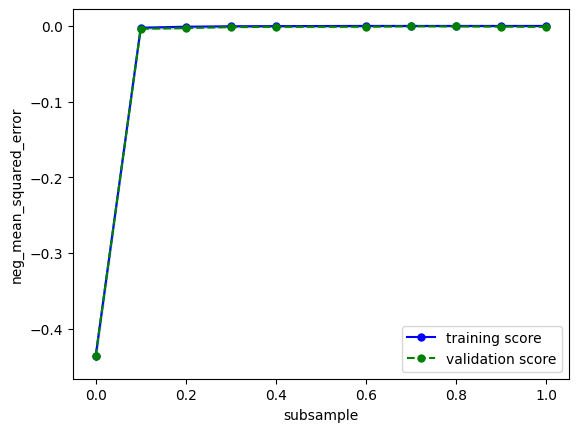

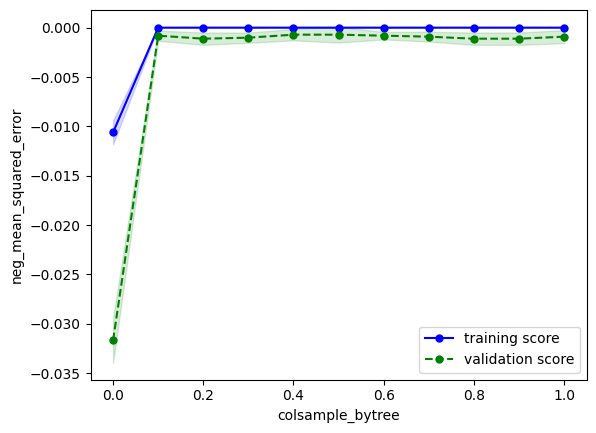

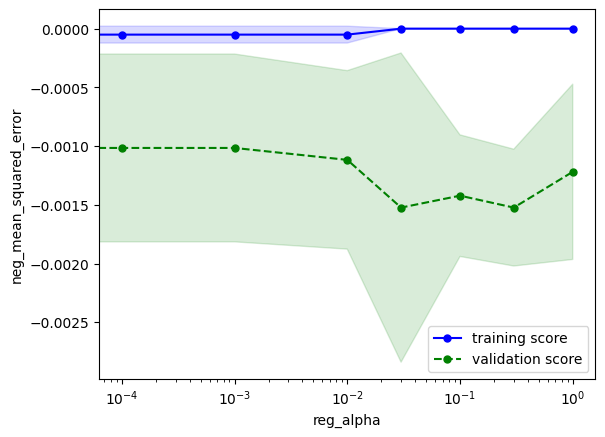

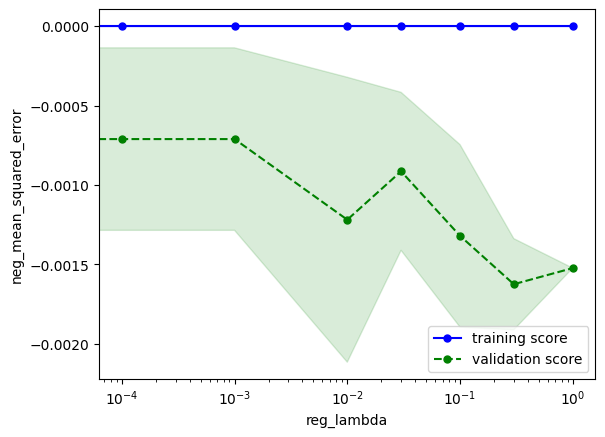

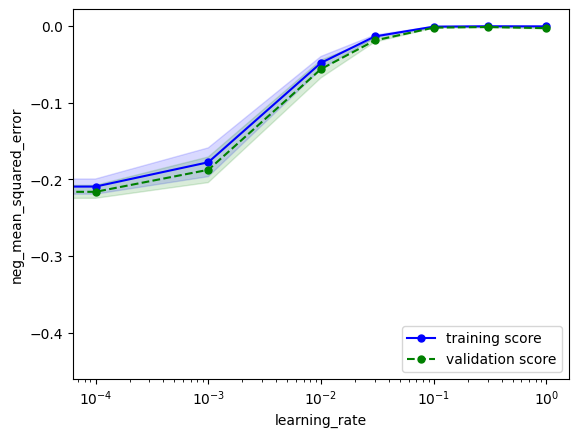

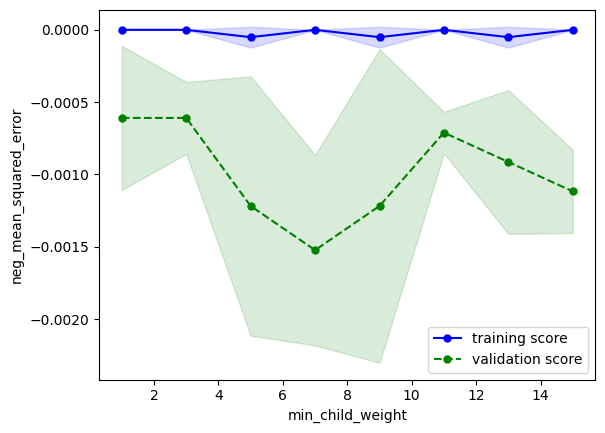

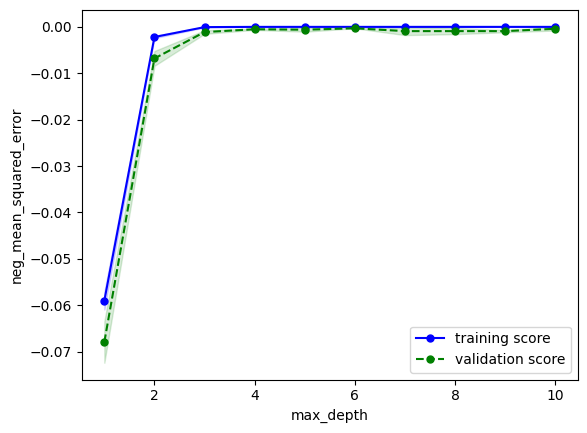

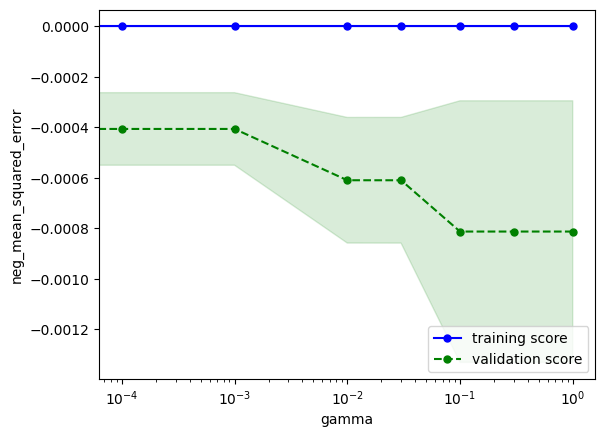

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

cv_params = {'subsample': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'reg_lambda': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'learning_rate': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'gamma': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0]
             }
param_scales = {'subsample': 'linear',
                'colsample_bytree': 'linear',
                'reg_alpha': 'log',
                'reg_lambda': 'log',
                'learning_rate': 'log',
                'min_child_weight': 'linear',
                'max_depth': 'linear',
                'gamma': 'log'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

ベイズ最適化（Optuna）の場合

In [8]:
import optuna
import time
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 8),
        'max_depth': trial.suggest_int('max_depth', 1, 4),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 0.1, log=True),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.1, log=True),
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler())
study.optimize(bayes_objective, n_trials=120)

# 最適パラメータの表示と保持
best_params = study.best_trial.params

best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

c:\Users\ohno\py_kn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-05-15 17:09:50,374] A new study created in memory with name: no-name-4f435634-5b59-409f-810b-7abdf105e403
[I 2023-05-15 17:10:02,367] Trial 0 finished with value: -0.001421649726222449 and parameters: {'learning_rate': 0.27129220992608033, 'min_child_weight': 3, 'max_depth': 3, 'colsample_bytree': 0.2499591056831114, 'subsample': 0.6768579750424888, 'reg_alpha': 0.043466272863958065, 'reg_lambda': 0.014904331523414463, 'gamma': 0.00032694463965151884}. Best is trial 0 with value: -0.001421649726222449.
[I 2023-05-15 17:10:11,747] Trial 1 finished with value: -0.08002538514382533 and parameters: {'learning_rate': 0.23217904092433309, 'min_child_weight': 4, 'max_depth': 1, 'colsample_bytree': 0.7279706972327487, 'subsample': 0.74199464813997

学習曲線

density X
Trial 24 finished with value: -0.00031709121657330094 and parameters: {'learning_rate': 0.23438544552825968, 'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.667695894112733, 'subsample': 0.8735879532622676, 'reg_alpha': 0.06062080789580933, 'reg_lambda': 0.02649834562029887, 'gamma': 0.00017347104196205915}. Best is trial 24 with value: -0.00031709121657330094.

Trial 110 finished with value: -0.00014092942958813373 and parameters: {'learning_rate': 0.2996664042991379, 'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.5900132407505827, 'subsample': 0.7861278628111913, 'reg_alpha': 0.0833769468777452, 'reg_lambda': 0.031653801601850814, 'gamma': 0.000513312410240226}. Best is trial 110 with value: -0.00014092942958813373.

Trial 356 finished with value: -0.005073459465172815 and parameters: {'learning_rate': 0.06993843495534138, 'min_child_weight': 2, 'max_depth': 4, 'colsample_bytree': 0.47094067052815364, 'subsample': 0.6066889384337291, 'reg_alpha': 0.04413055357657462, 'reg_lambda': 0.009204146079507272, 'gamma': 0.0015121226807088752}. Best is trial 354 with value: -7.046471479406687e-05.

In [ ]:
from sklearn.metrics import classification_report
model.fit(ML.X_train_pca, ML.y_train)
pred = model.predict(ML.X_test)
# svmres = pd.DataFrame(np.array([self.path_test, self.y_test, pred]).T, columns=["path", "y", "predict"])
print(classification_report(ML.y_test, pred))

c:\Users\lkxl1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.32      0.33      0.32      3932
         1.0       0.16      0.15      0.16      3299

    accuracy                           0.25      7231
   macro avg       0.24      0.24      0.24      7231
weighted avg       0.25      0.25      0.25      7231



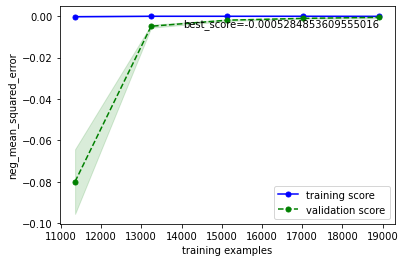

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
best_params = {'learning_rate': 0.23438544552825968, 'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.667695894112733, 'subsample': 0.8735879532622676, 'reg_alpha': 0.06062080789580933, 'reg_lambda': 0.02649834562029887, 'gamma': 0.00017347104196205915}

best_score = -7.046471479406687e-05
model.set_params(**best_params)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=X, y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

検証曲線

In [ ]:
from sklearn.model_selection import validation_curve
# 検証曲線描画対象パラメータ
valid_curve_params = {'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
                      'min_child_weight': [2, 3, 4, 5, 6, 7, 8],
                      'max_depth': [1, 2, 3, 4],
                      'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                      'subsample': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                      'reg_alpha': [0.001, 0.003, 0.01, 0.03, 0.1],
                      'reg_lambda': [0.001, 0.003, 0.01, 0.03, 0.1],
                      'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
                      }
param_scales = {'learning_rate': 'log',
                'min_child_weight': 'linear',
                'max_depth': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',                
                'reg_alpha': 'log',
                'reg_lambda': 'log',                
                'gamma': 'log'
                }
# 最適パラメータを上記描画対象に追加
for k, v in valid_curve_params.items():
    if best_params[k] not in v:
        v.append(best_params[k])
        v.sort()
for i, (k, v) in enumerate(valid_curve_params.items()):
    # モデルに最適パラメータを適用
    model.set_params(**best_params)
    # 検証曲線を描画
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # 最適パラメータを縦線表示
    plt.axvline(x=best_params[k], color='gray')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()